In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 263, 6, Finished, Available, Finished)

In [2]:
# Load the data
df = pd.read_parquet("Uberdata.parquet")

df = df.drop(['dispatching_base_num', 'originating_base_num','request_datetime','on_scene_datetime',
'pickup_datetime','dropoff_datetime'], axis=1)

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 263, 7, Finished, Available, Finished)

In [3]:

# Print column names to verify
print("Columns in the dataframe:")
print(df.columns.tolist())

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Define a function for monthly aggregation
def prepare_monthly_data(df):
    agg_dict = {
        'estimated_emissions': 'mean',
        'average_speed': 'mean',
        'congestion_surcharge': 'mean',
        'driver_pay': 'mean'
    }
    # Resample to monthly frequency and aggregate
    df_monthly = df.set_index('date').resample('M').agg(agg_dict)
    return df_monthly

# Aggregate data to monthly frequency
df_monthly = prepare_monthly_data(df)

# Drop rows with missing values
df_monthly = df_monthly.dropna()

# Display the first few rows of aggregated data
print("Sample Aggregated Data:")
print(df_monthly.head())

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 263, 8, Finished, Available, Finished)

Columns in the dataframe:
['PULocationID', 'DOLocationID', 'trip_miles', 'trip_time', 'base_passenger_fare', 'bcf', 'sales_tax', 'congestion_surcharge', 'driver_pay', 'date', 'month', 'day', 'estimated_emissions', 'average_speed', 'estimated_levels', 'speed_category']
Sample Aggregated Data:
            estimated_emissions  average_speed  congestion_surcharge  \
date                                                                   
2020-01-31           520.345407      11.348412              0.804328   
2020-02-29           519.176150      11.330530              0.794997   
2020-03-31           541.209385      11.845373              0.707791   
2020-04-30           620.618757      13.758839              0.691062   
2020-05-31           621.541527      13.642517              0.711621   

            driver_pay  
date                    
2020-01-31    2.433957  
2020-02-29    2.473833  
2020-03-31    2.508037  
2020-04-30    2.497540  
2020-05-31    2.505447  


In [4]:
from sklearn.preprocessing import StandardScaler

# Define exogenous variables
exog_vars = df_monthly[['average_speed', 'congestion_surcharge', 'driver_pay']]

# Scale the exogenous variables
scaler = StandardScaler()
exog_vars_scaled = pd.DataFrame(
    scaler.fit_transform(exog_vars),
    columns=exog_vars.columns,
    index=exog_vars.index
)

# Prepare the target variable
target = df_monthly['estimated_emissions']


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 263, 9, Finished, Available, Finished)

In [5]:
train_target = target[:-12]
test_target = target[-12:]
train_exog = exog_vars_scaled[:-12]
test_exog = exog_vars_scaled[-12:]


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 263, 10, Finished, Available, Finished)

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 263, 13, Finished, Available, Finished)

SARIMA Residuals (Training):
date
2020-01-31    585.296660
2020-02-29     -0.886004
2020-03-31      0.468400
2020-04-30     -0.371834
2020-05-31      5.523753
Freq: M, dtype: float64

Final Forecast Accuracy Metrics:
Mean Absolute Error (MAE): 2.9368
Root Mean Squared Error (RMSE): 3.2363


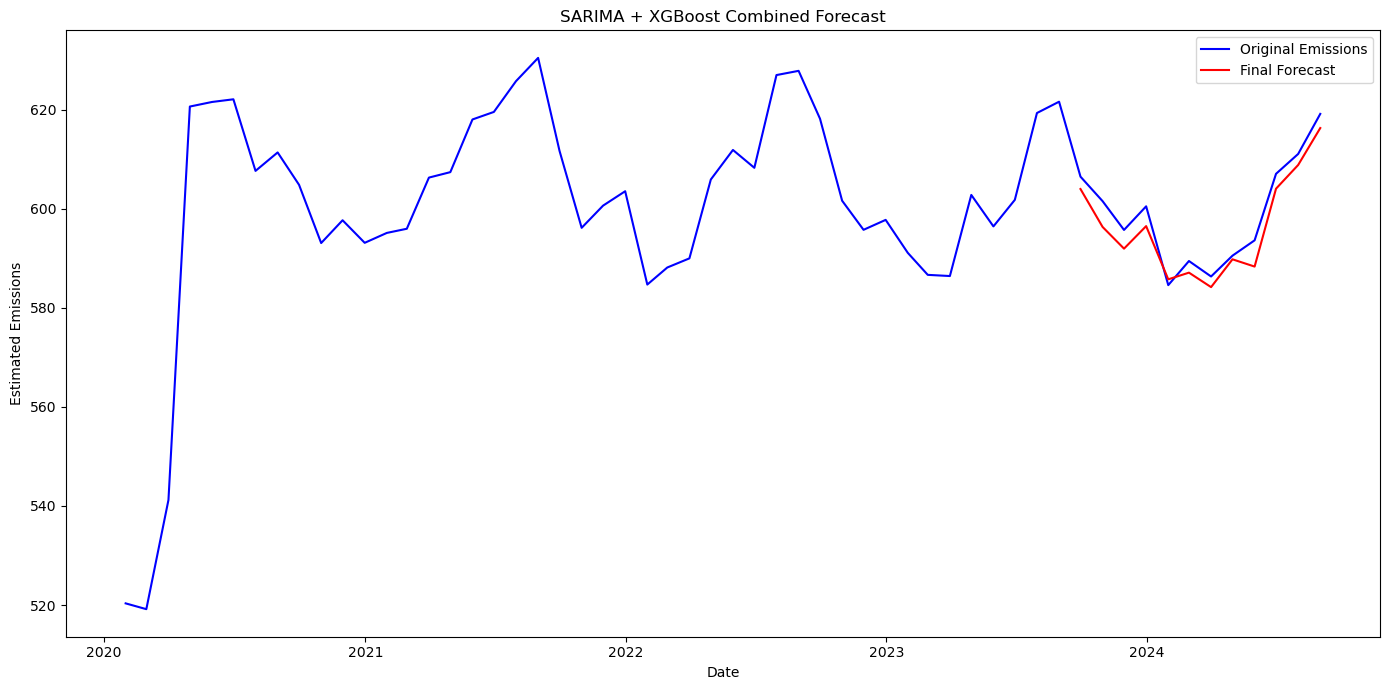

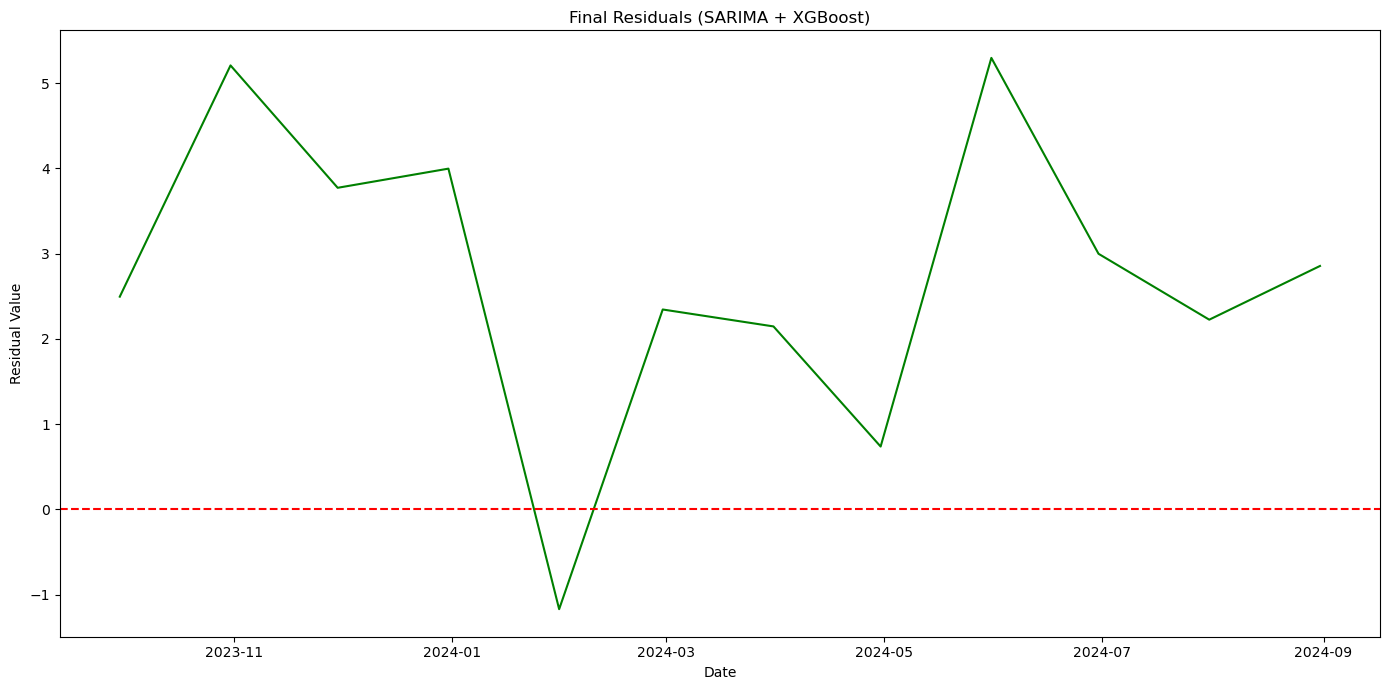

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Train SARIMA Model
# Define and fit the SARIMA model
sarima_model = SARIMAX(
    train_target,
    exog=train_exog,  # Use scaled exogenous variables
    order=(1, 1, 1),  # ARIMA(p, d, q) parameters
    seasonal_order=(1, 0, 1, 12)  # Seasonal (P, D, Q, s)
)
sarima_results = sarima_model.fit(disp=False)

# Generate SARIMA predictions
sarima_forecast = sarima_results.get_prediction(
    start=test_target.index[0],
    end=test_target.index[-1],
    exog=test_exog  # Use scaled test exogenous variables
).predicted_mean

# Calculate SARIMA residuals
sarima_residuals = train_target - sarima_results.fittedvalues

# Display residuals
print("SARIMA Residuals (Training):")
print(sarima_residuals.head())

# Step 2: Train XGBoost on SARIMA Residuals
# Prepare training data for XGBoost
X_train = train_exog
y_train = sarima_residuals

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    alpha=1,  # L1 regularization
    reg_lambda=1  # Correct L2 regularization term
)


# Train XGBoost model on residuals
xgb_model.fit(X_train, y_train)

# Predict residuals for the test set using XGBoost
xgb_residual_forecast = xgb_model.predict(test_exog)

# Step 3: Combine SARIMA and XGBoost Predictions
# Final forecast = SARIMA forecast + XGBoost residual forecast
final_forecast = sarima_forecast + xgb_residual_forecast

# Step 4: Evaluate Final Forecast
# Calculate accuracy metrics
mae = mean_absolute_error(test_target, final_forecast)
rmse = np.sqrt(mean_squared_error(test_target, final_forecast))

print("\nFinal Forecast Accuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Step 5: Visualize Results
# Plot original vs forecast
plt.figure(figsize=(14, 7))
plt.plot(target.index, target, label='Original Emissions', color='blue')
plt.plot(test_target.index, final_forecast, label='Final Forecast', color='red')
plt.title('SARIMA + XGBoost Combined Forecast')
plt.xlabel('Date')
plt.ylabel('Estimated Emissions')
plt.legend()
plt.tight_layout()
plt.show()

# Plot residuals of the final model
final_residuals = test_target - final_forecast
plt.figure(figsize=(14, 7))
plt.plot(final_residuals.index, final_residuals, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title('Final Residuals (SARIMA + XGBoost)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.tight_layout()
plt.show()
